### 5.7 Exercise
Redefine the model to be w2 * t_u ** 2 + w1 * t_u + b.
1. What parts of the training loop, and so on, need to change to accommodate this redefinition?
2. What parts are agnostic to swapping out the model?
3. Is the resulting loss higher or lower after training?
4. Is the actual result better or worse?

In [1]:
%matplotlib inline
import numpy as np
import torch
torch.set_printoptions(edgeitems=2, linewidth=75)

In [2]:
t_c = [0.5,  14.0, 15.0, 28.0, 11.0,  8.0,  3.0, -4.0,  6.0, 13.0, 21.0]
t_u = [35.7, 55.9, 58.2, 81.9, 56.3, 48.9, 33.9, 21.8, 48.4, 60.4, 68.4]
t_c = torch.tensor(t_c)
t_u = torch.tensor(t_u)

In [3]:
def model(t_u, w1, w2, b):
    return w2 * t_u ** 2 + w1 * t_u + b

In [4]:
def loss_fn(t_p, t_c):
    squared_diffs = (t_p - t_c)**2
    return squared_diffs.mean()

In [5]:
w1 = torch.ones(())
w2 = torch.ones(())
b = torch.zeros(())

t_p = model(t_u, w1, w2, b)
t_p

tensor([1310.1901, 3180.7100, 3445.4399, 6789.5103, 3225.9900, 2440.1101,
        1183.1101,  497.0399, 2390.9600, 3708.5601, 4746.9600])

In [6]:
loss = loss_fn(t_p, t_c)
loss

tensor(11709471.)

In [7]:
delta = 0.1

loss_rate_of_change_w1 = \
    (loss_fn(model(t_u, w1, w2 + delta, b), t_c) - 
     loss_fn(model(t_u, w1, w2 - delta, b), t_c)) / (2.0 * delta)

loss_rate_of_change_w2 = \
    (loss_fn(model(t_u, w1, w2 + delta, b), t_c) - 
     loss_fn(model(t_u, w1, w2 - delta, b), t_c)) / (2.0 * delta)

In [8]:
learning_rate = 1e-5

w1 = w1 - learning_rate * loss_rate_of_change_w1

w2 = w2 - learning_rate * loss_rate_of_change_w2

In [9]:
loss_rate_of_change_b = \
    (loss_fn(model(t_u, w1, w2, b + delta), t_c) - 
     loss_fn(model(t_u, w1, w2, b - delta), t_c)) / (2.0 * delta)

b = b - learning_rate * loss_rate_of_change_b

In [10]:
def dloss_fn(t_p, t_c):
    dsq_diffs = 2 * (t_p - t_c) / t_p.size(0)  # <1>
    return dsq_diffs

In [11]:
def dmodel_dw1(t_u, w1, b):
    return t_u

In [12]:
def dmodel_dw2(t_u, w2, b):
    return t_u

In [13]:
def dmodel_db(t_u, w1, w2, b):
    return 1.0

In [14]:
def grad_fn(t_u, t_c, t_p, w1, w2, b):
    dloss_dtp = dloss_fn(t_p, t_c)
    dloss_dw1 = dloss_dtp * dmodel_dw1(t_u, w1, b)
    dloss_dw2 = dloss_dtp * dmodel_dw2(t_u, w2, b)
    dloss_db = dloss_dtp * dmodel_db(t_u, w1, w2, b)
    return torch.stack([dloss_dw1.sum(), dloss_dw2.sum(), dloss_db.sum()])  # <1>

In [15]:
def training_loop(n_epochs, learning_rate, params, t_u, t_c,
                  print_params=True):
    for epoch in range(1, n_epochs + 1):
        w1, w2, b = params

        t_p = model(t_u, w1, w2, b)  # <1>
        loss = loss_fn(t_p, t_c)
        grad = grad_fn(t_u, t_c, t_p, w1, w2, b)  # <2>

        params = params - learning_rate * grad

        if epoch in {1, 2, 3, 10, 11, 99, 100, 4000, 5000}:  # <3>
            print('Epoch %d, Loss %f' % (epoch, float(loss)))
            if print_params:
                print('    Params:', params)
                print('    Grad:  ', grad)
        if epoch in {4, 12, 101}:
            print('...')

        if not torch.isfinite(loss).all():
            break  # <3>
            
    return params

In [16]:
training_loop(
    n_epochs = 100, 
    learning_rate = 1e-2, 
    params = torch.tensor([1.0, 1.0, 0.0]), 
    t_u = t_u, 
    t_c = t_c)

Epoch 1, Loss 11709471.000000
    Params: tensor([-3617.1025, -3617.1025,   -59.6420])
    Grad:   tensor([361810.2500, 361810.2500,   5964.1963])
Epoch 2, Loss 154402413346816.000000
    Params: tensor([13132854.0000, 13132854.0000,   216432.4688])
    Grad:   tensor([-1.3136e+09, -1.3136e+09, -2.1649e+07])
Epoch 3, Loss 2035399740527770337280.000000
    Params: tensor([-4.7682e+10, -4.7682e+10, -7.8581e+08])
    Grad:   tensor([4.7695e+12, 4.7695e+12, 7.8603e+10])
...


tensor([2.2822e+21, 2.2822e+21, 3.7611e+19])

In [17]:
training_loop(
    n_epochs = 100, 
    learning_rate = 1e-4, 
    params = torch.tensor([1.0, 1.0, 0.0]), 
    t_u = t_u, 
    t_c = t_c)

Epoch 1, Loss 11709471.000000
    Params: tensor([-35.1810, -35.1810,  -0.5964])
    Grad:   tensor([361810.2500, 361810.2500,   5964.1963])
Epoch 2, Loss 14609815552.000000
    Params: tensor([1242.6470, 1242.6470,   20.4623])
    Grad:   tensor([-12778280.0000, -12778280.0000,   -210587.5312])
Epoch 3, Loss 18223183429632.000000
    Params: tensor([-43887.2031, -43887.2031,   -723.2882])
    Grad:   tensor([4.5130e+08, 4.5130e+08, 7.4375e+06])
...
Epoch 10, Loss 85606277184670473845879218162892800.000000
    Params: tensor([3.0080e+15, 3.0080e+15, 4.9573e+13])
    Grad:   tensor([-3.0932e+19, -3.0932e+19, -5.0976e+17])
Epoch 11, Loss inf
    Params: tensor([-1.0624e+17, -1.0624e+17, -1.7508e+15])
    Grad:   tensor([1.0924e+21, 1.0924e+21, 1.8004e+19])


tensor([-1.0624e+17, -1.0624e+17, -1.7508e+15])

In [18]:
t_un = 0.1 * t_u

In [19]:
training_loop(
    n_epochs = 100, 
    learning_rate = 1e-2, 
    params = torch.tensor([1.0, 1.0, 0.0]), 
    t_u = t_un, # <1>
    t_c = t_c)

Epoch 1, Loss 675.794312
    Params: tensor([-1.7968, -1.7968, -0.4818])
    Grad:   tensor([279.6790, 279.6790,  48.1760])
Epoch 2, Loss 7072.701172
    Params: tensor([7.0940, 7.0940, 0.9808])
    Grad:   tensor([-889.0812, -889.0812, -146.2582])
Epoch 3, Loss 70292.179688
    Params: tensor([-21.1622, -21.1622,  -3.7362])
    Grad:   tensor([2825.6179, 2825.6179,  471.6975])
...
Epoch 10, Loss 757163360256.000000
    Params: tensor([70421.4688, 70421.4688, 11714.6621])
    Grad:   tensor([-9257782.0000, -9257782.0000, -1540080.3750])
Epoch 11, Loss 7648660422656.000000
    Params: tensor([-223820.8438, -223820.8438,  -37234.1484])
    Grad:   tensor([29424232.0000, 29424232.0000,  4894881.5000])
...


tensor([8.0326e+17, 8.0326e+17, 1.3363e+17])

In [20]:
params = training_loop(
    n_epochs = 5000, 
    learning_rate = 1e-5, 
    params = torch.tensor([1.0, 1.0, 0.0]), 
    t_u = t_un, 
    t_c = t_c,
    print_params = False)

params

Epoch 1, Loss 675.794312
Epoch 2, Loss 670.135925
Epoch 3, Loss 664.525024
...
Epoch 10, Loss 626.549805
Epoch 11, Loss 621.305908
...
Epoch 99, Loss 297.324982
Epoch 100, Loss 294.858124
...
Epoch 4000, Loss 9.719714
Epoch 5000, Loss 9.678194


tensor([ 0.3326,  0.3326, -0.1930])

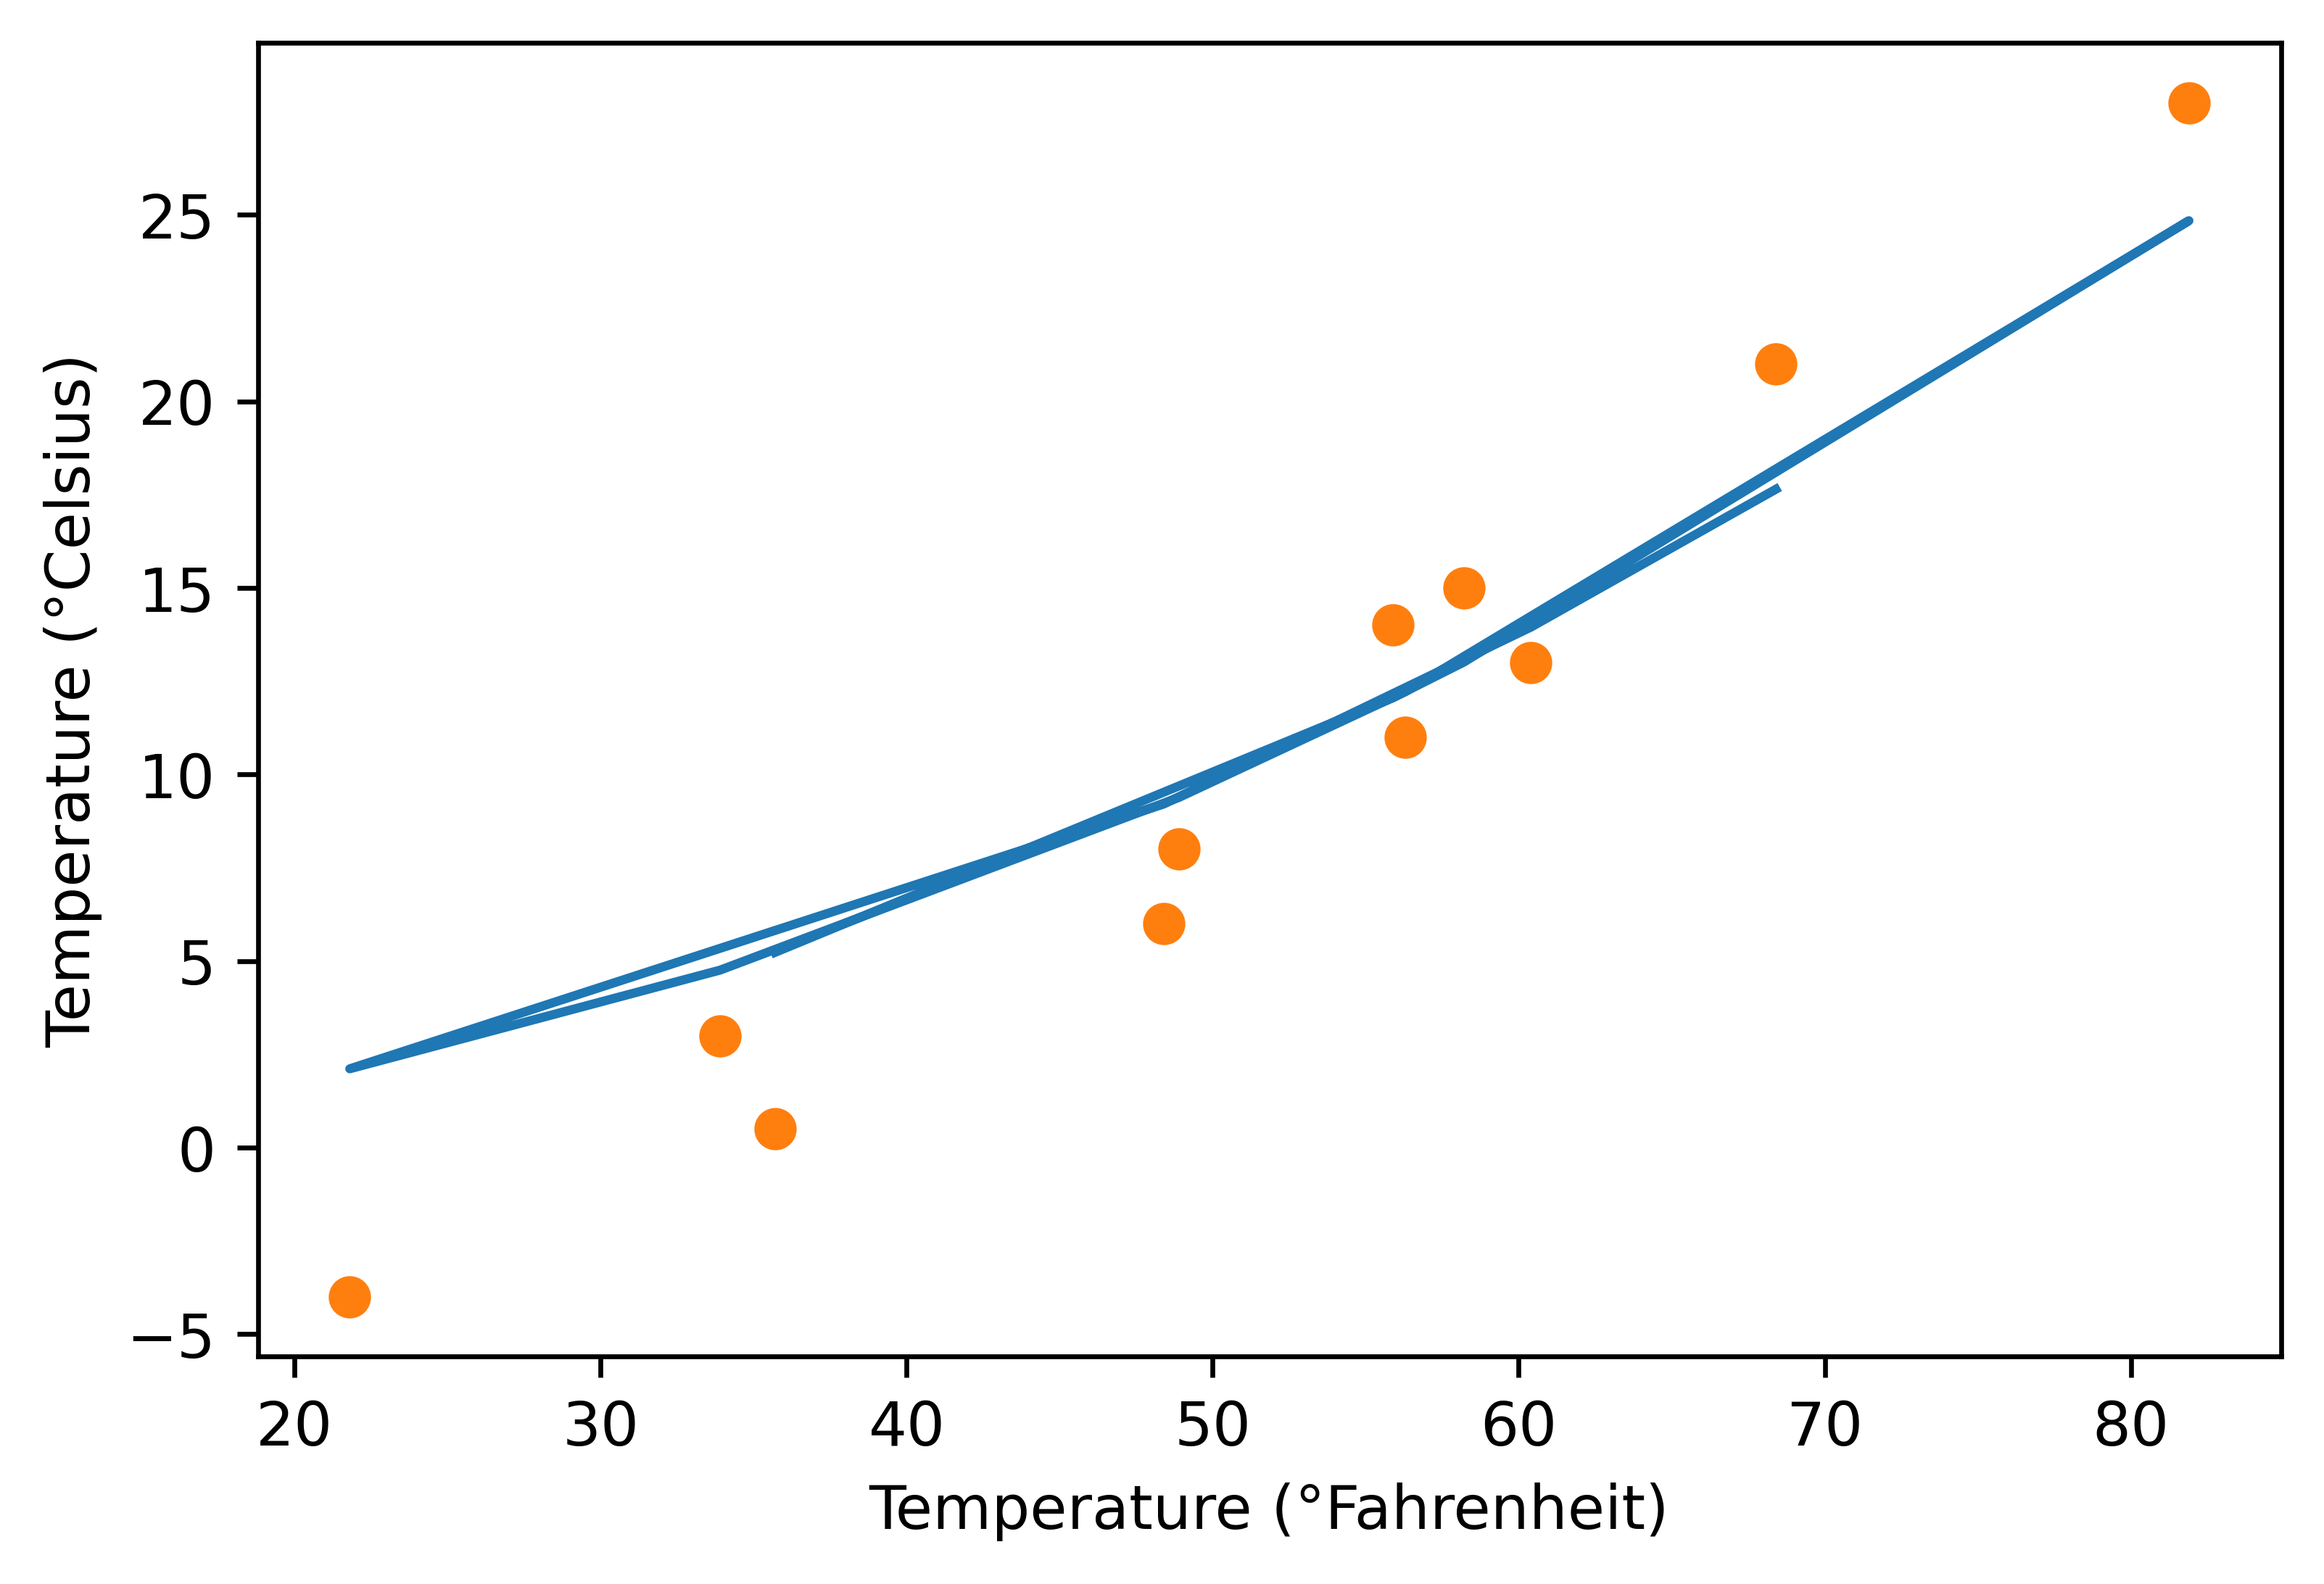

In [21]:
%matplotlib inline
from matplotlib import pyplot as plt

t_p = model(t_un, *params)  # <1>

fig = plt.figure(dpi=600)
plt.xlabel("Temperature (°Fahrenheit)")
plt.ylabel("Temperature (°Celsius)")
plt.plot(t_u.numpy(), t_p.detach().numpy()) # <2>
plt.plot(t_u.numpy(), t_c.numpy(), 'o')
plt.savefig("temp_unknown_plot.png", format="png")  # bookskip

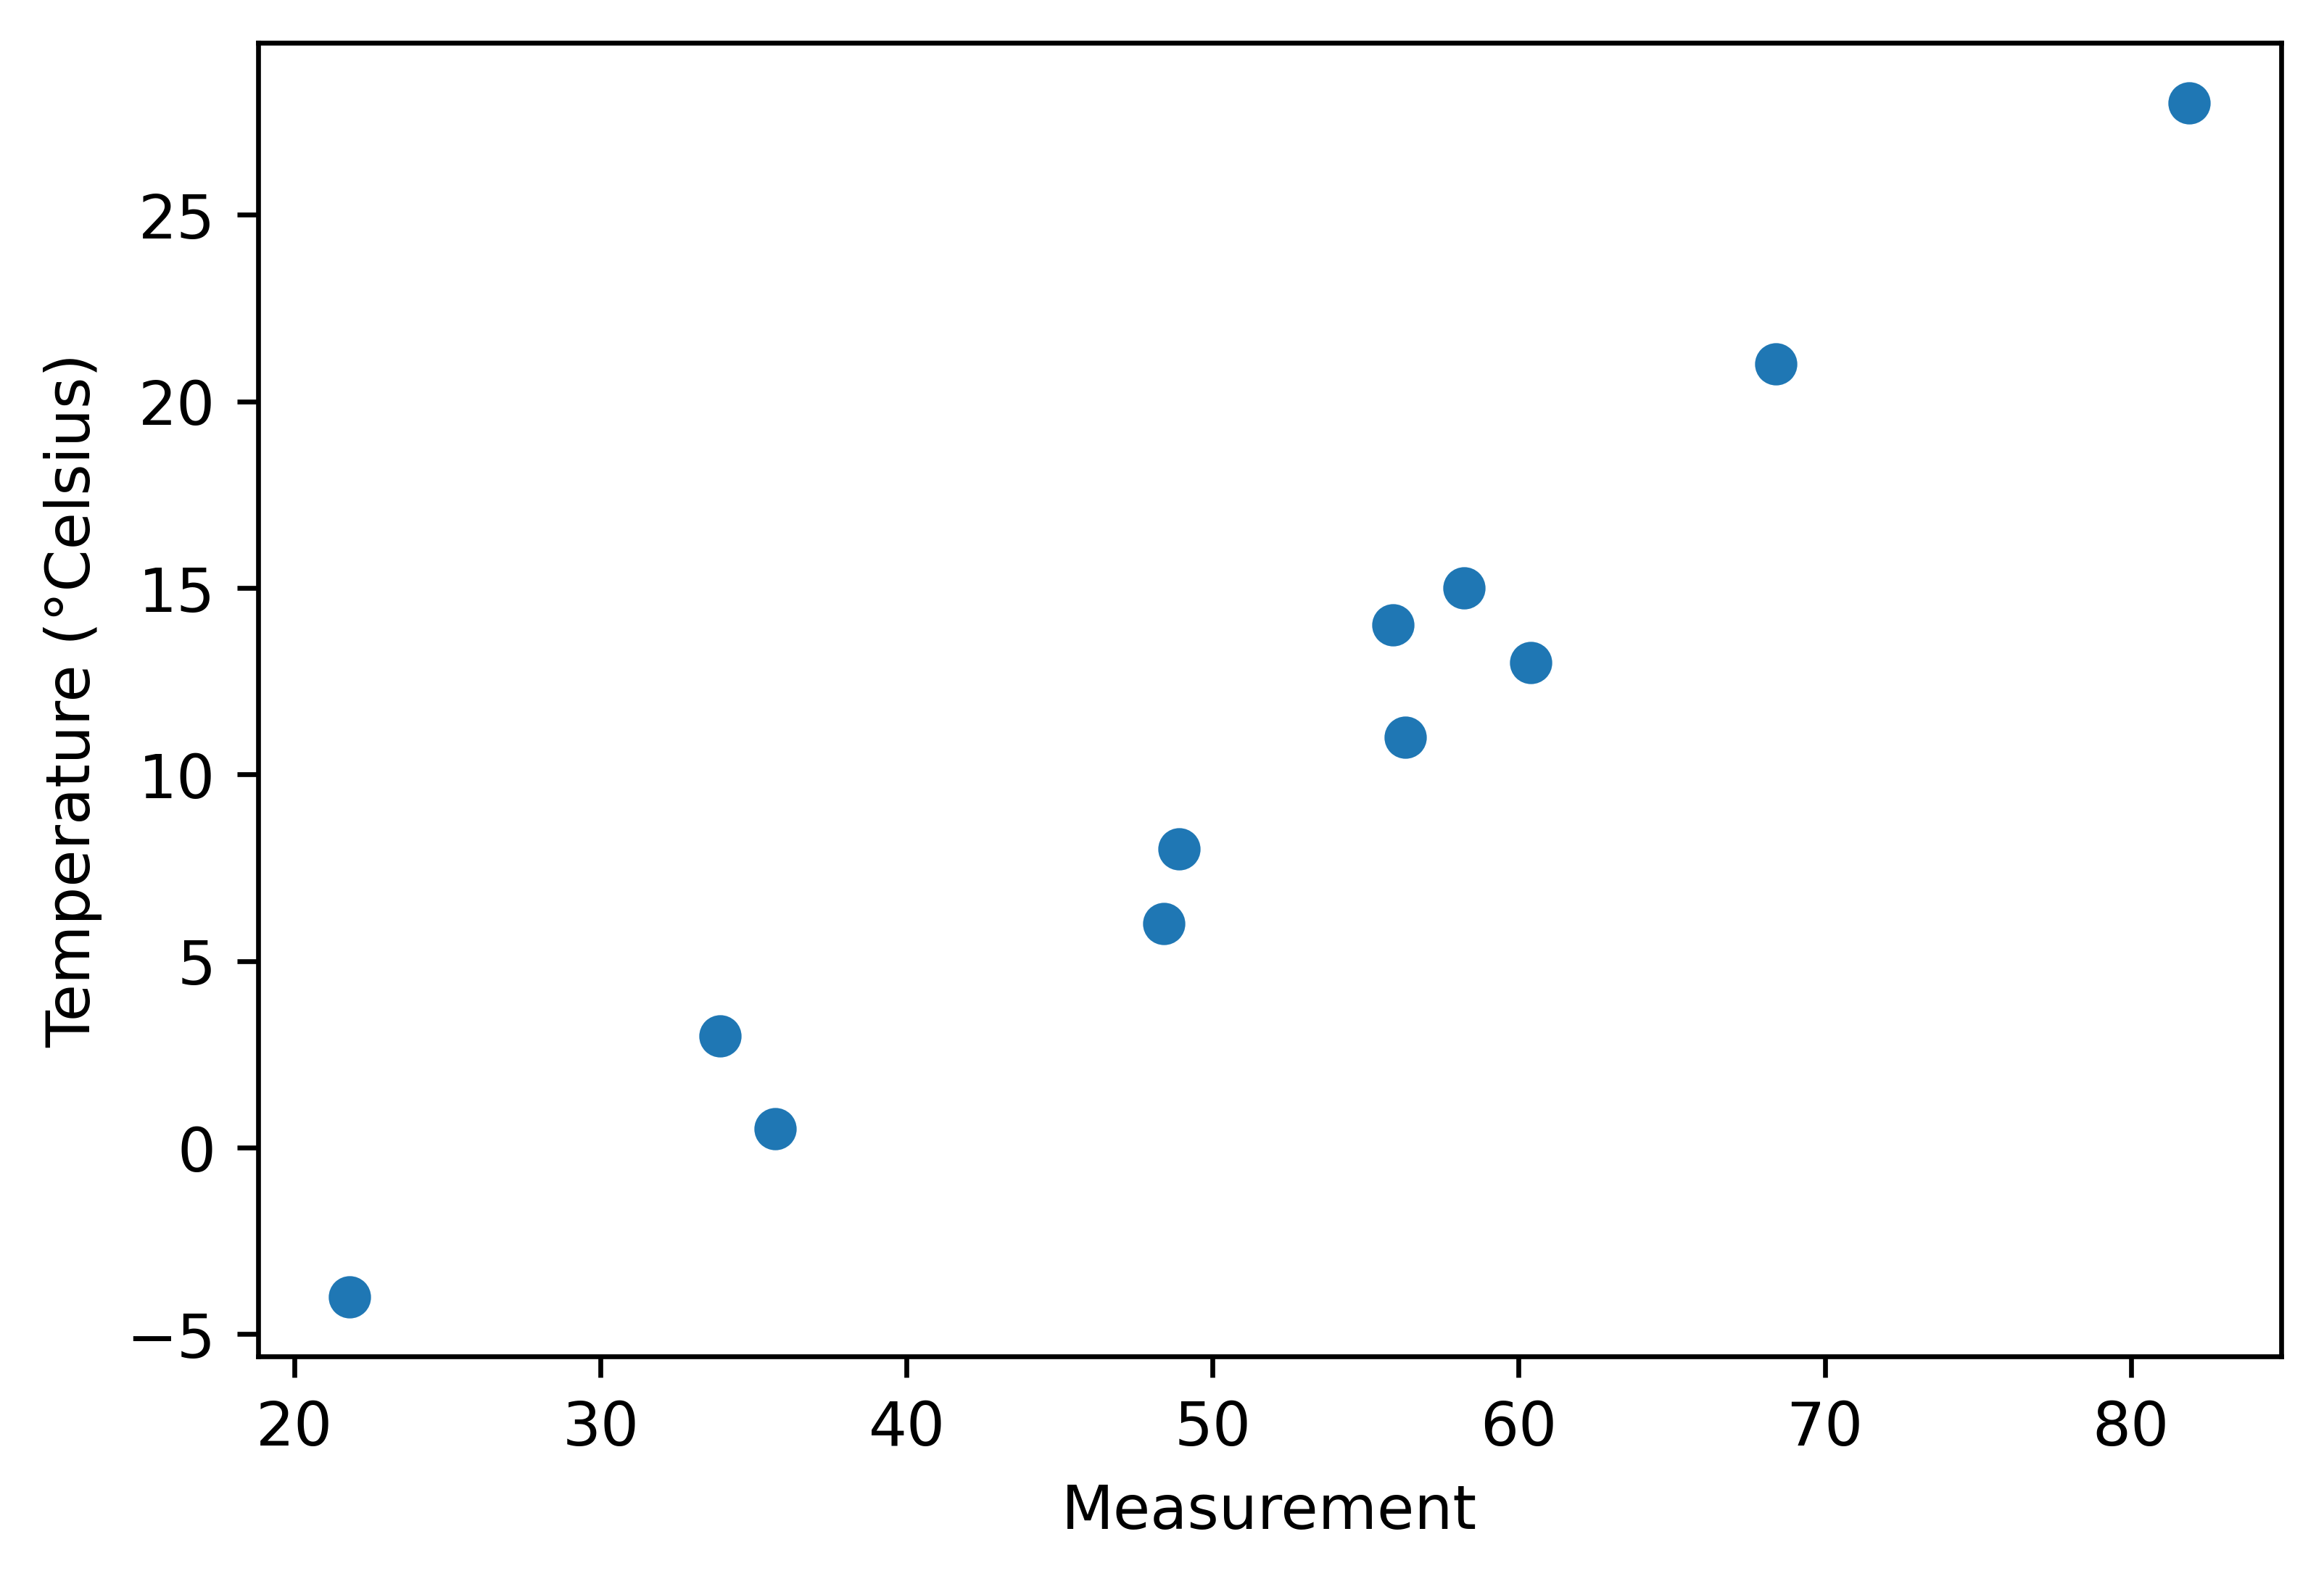

In [22]:
%matplotlib inline
from matplotlib import pyplot as plt

fig = plt.figure(dpi=600)
plt.xlabel("Measurement")
plt.ylabel("Temperature (°Celsius)")
plt.plot(t_u.numpy(), t_c.numpy(), 'o')

plt.savefig("temp_data_plot.png", format="png")